## Tarea 5: El sistema de cúmulos globulares de M87

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [ ]:
# Extraemos las imagenes
hdu_f475w = fits.open('f475w.fits')
hdu_f850lp = fits.open('f850lp.fits')

#SCI_f475w = (hdu_f475w['SCI']).writeto('sci_f475w_m87.fits')
#WHT_f475w = (hdu_f475w['WHT']).writeto('invar_f475w_m87.fits')
#SCI_f850lp = (hdu_f850lp['SCI']).writeto('sci_f850lp_m87.fits')
#WHT_f850lp = (hdu_f850lp['WHT']).writeto('invar_f850lp_m87.fits')

hdu_f850lp.close()
hdu_f475w.close()

In [2]:
# Cargamos los catálogos
MAG_f475w = np.loadtxt('output_f475w.cat')
MAG_f850lp = np.loadtxt('output_f850lp.cat')
RA_f475w, DEC_f475w = MAG_f475w[:,3], MAG_f475w[:,4]
RA_f850lp, DEC_f850lp = MAG_f850lp[:,3], MAG_f850lp[:,4]

# Match entre las estrellas de cada filtro
c = SkyCoord(ra=RA_f850lp*u.degree, dec=DEC_f850lp*u.degree)  
catalog = SkyCoord(ra=RA_f475w*u.degree, dec=DEC_f475w*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  

F475W = (MAG_f475w[idx])[:,1]
F850lp = MAG_f850lp[:,1]

Ahora debemos realizar correciones de apertura, de punto cero y correción por reddening. 
Para la correción de apertura debemos extrapolar dichas corrreciones a partir de los valores mostrados en la tabla 6. Para ello usamos que el pixel scale para WFC es de 0.05''/pix ([ACS Detectors](http://www.stsci.edu/hst/acs/Detector/)), por lo tanto, para una apertura de 4 pixeles de diámetro, el radio de apertura en arcosegundos corresponde a 0.1 (segunda columna de la tabla 6 del paper de Sirianni).
A continuación, se realiza la interpolación para determinar la correción de apertura para F475W y F850LP (*estructura de código extraida de la pauta de la tarea 1.1*)

Correccion apertura F850lp:  0.7259448
Correccion apertura F475W:  0.45667516


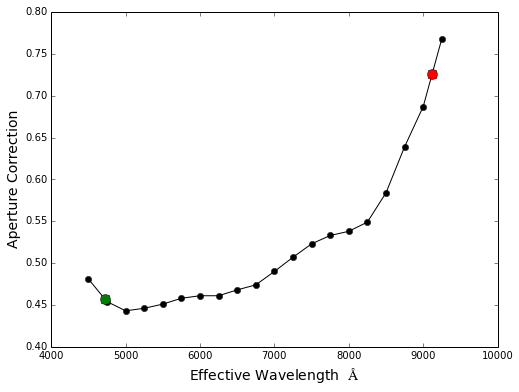

In [67]:
from scipy.interpolate import interp1d

eff_wav = np.arange(4500, 9251, 250)  # Array de longitudes de onda efectiva (eff_wav). 
                                      # Los extremos corresponden a las eff_wav de F475W y F850LP 

# Correcciones de apertura para cada eff_wav. Valores extraidos de tabla 6 de Sirianni et al. 2005
corr    = np.array([0.481, 0.454, 0.443, 0.446, 0.451, 0.458, 0.461, \
                    0.461, 0.468, 0.474, 0.490, 0.507, 0.523, 0.533, \
                    0.538, 0.549, 0.584, 0.639, 0.687, 0.768])

apcorr = interp1d(eff_wav, corr)

# Interpolación para F475W y F850LP
ac475 = apcorr(4725.23)
ac850 = apcorr(9120.2)

print 'Correccion apertura F850lp: ', ac850
print 'Correccion apertura F475W: ', ac475

fig, ax = plt.subplots(figsize=[8,6])
ax.plot(eff_wav, corr, '-ok')
ax.plot(9120.2, ac850, 'or', ms=10)
ax.plot(4725.23, ac475, 'og', ms=10)
ax.set_xlabel('Effective Wavelength  $\AA$', fontsize = 14)
ax.set_ylabel('Aperture Correction', fontsize = 14)

Para los Zeropoint (ZPT), elegimos el sistema fotométrico ABMAG para efectos de comparar los resultados finales con los gráficos de distribución de densidad para M87 mostrados en [Peng et al. 2006](http://iopscience.iop.org/article/10.1086/498210/pdf). Los valores de ZPT para cada filtro fueron extraidos de la tabla 10 de [Sirianni et al. 2005](http://iopscience.iop.org/article/10.1086/444553/pdf). 

Para determinar las correciones por reddening utilizamos los valores de la tabla 14 de Sirianni et al. y los multiplicamos por el valor de $A_B - A_V$ extraido del [NED](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=M87&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES). 

In [4]:
# Zeropoint
ZPT_F475W  = 26.068
ZPT_F850lp = 24.862

# Absortion
A_B, A_V = 0.083, 0.063          # Extincion de M87 en las bandas B y V
A_F475W = 3.555 * (A_B - A_V)    # Extinción para F475W
A_F850lp = 1.471 * (A_B - A_V)   # Extinción para F850LP

# Aperture Correction
apcor_F475W = ac475
apcor_F850lp = ac850

# Applying corrections
F475W = F475W + ZPT_F475W - apcor_F475W - A_F475W
F850lp = F850lp + ZPT_F850lp - apcor_F850lp - A_F850lp

Con las magnitudes corregidas, comparamos el histograma de $g-z$ obtenido en esta tarea y la mostrada en la figura 2 (plot 1316) del paper de [Peng et al. 2006](http://iopscience.iop.org/article/10.1086/498210/pdf). Observamos que nuestro histograma corresponde a una distribución bimodal, bien modelada por 2 distribuciones normales, lo que es consistente con los resultados obtenidos por Peng. Sin embargo, el número de cúmulos obtenidos para cada peak no coincide con los resultados del paper. Esto podría deberse a la elección de un threshold muy alto (lo que eliminaría los objetos débiles) o que el ancho de los bins no es el adecuado. 

A continuación se muestra el histograma de $g-z$ más el (mejor) modelo que se ajusta a la distribución bimodal y que entrega los valores óptimos de $\mu$ y $\sigma$ de cada gaussiana (*Código*: [stackoverflow](http://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python))


mu1: 0.988143  sigma1: 0.128419
mu2: 1.437359  sigma2: 0.148341


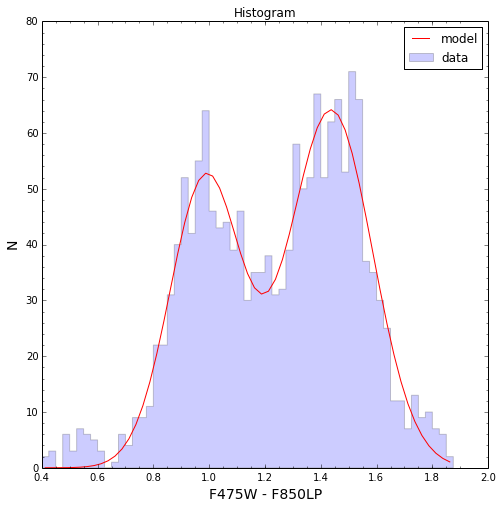

In [71]:
from scipy.optimize import curve_fit

bins = np.arange(0.4, 1.9, 0.025)
data= F475W - F850lp

plt.figure(figsize=[8,8])
y,x,_= plt.hist(data,bins=bins, histtype='stepfilled', alpha=0.2,label='data')

x=(x[1:]+x[:-1])/2 

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

guess=(1,.2,105,1.5,.2,115)
params,cov=curve_fit(bimodal,x,y,guess)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=1,label='model')
plt.xlabel('F475W - F850LP', fontsize = 14)
plt.ylabel('N', fontsize = 14)
plt.title('Histogram')
plt.minorticks_on()
plt.legend()

print "\nmu1: %f  sigma1: %f" %(params[0], params[1])
print "mu2: %f  sigma2: %f" %(params[3], params[4])

Ahora, por lo visto en clases y lo explicado en [Jordán et al. 2006](https://arxiv.org/pdf/astro-ph/0609371.pdf), podemos usar el Globular Cluster Luminosity Function (GCLF) para estimar la distancia a M87. De esta manera, consideramos el peak de la distribución en $z$ como la magnitud aparente del cúmulo y usando $M_z = -8.4$ (determinado en el paper) como la magnitud absoluta de M87, obtenemos el módulo de distancia. 

Para determinar de manera precisa la media de la distribución en $z$ ajustamos una gaussiana donde $\mu$ correspondería a la magnitud aparente buscada y $\sigma$ su error.


mu: 22.861863  sigma: 1.177912


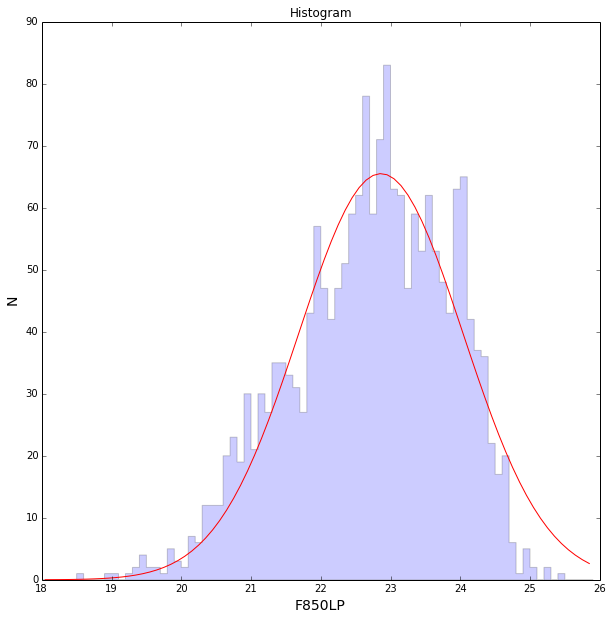

In [73]:
bins = np.arange(18,26,0.1)
plt.figure(figsize=[10,10])
y,x,_ = plt.hist(F850lp,bins=bins,histtype='stepfilled', alpha=0.2,label='data')

x=(x[1:]+x[:-1])/2 
guess = (23,1.0,160)

params, cov = curve_fit(gauss,x,y,guess)
sigma = sqrt(diag(cov))

plt.plot(x, gauss(x, *params), color='red',lw=1, label='model')
plt.xlabel('F850LP', fontsize = 14)
plt.ylabel('N', fontsize = 14)
plt.title('Histogram')

print "\nmu: %f  sigma: %f" %(params[0], params[1])

Así, utilizando la fórmula de módulo de distancia (ecuación 1) obtenemos una estimación para la distancia a M87. Además, por propagación de errores, determinamos la incerteza de dicha distancia utilizando el $\sigma$ determinado anteriormente.

$$d = 10^{\frac{m_z - M_z}{5} + 1} \hspace{1cm} (1)$$  

$$\Delta d = \left(\frac{\partial d}{\partial m_z}\right) \Delta m_z = 10^{\frac{m_z - M_z}{5} + 1} \ln10 \cdot \frac{\sigma}{5} \hspace{1cm} (2) $$

In [74]:
mu = params[0]
sigma = params[1]

d = 10**((mu + 8.4 + 5)/5.) 
erd = (d*np.log(10)/5)*sigma  # propagación de error
print "Distancia a M87:", d/1e6, '+-', erd/1e6, "Mpc"

Distancia a M87: 17.8802069078 +- 9.69909174795 Mpc
